<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Multinomial Regression</p>

*Import Libraries*

In [61]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings

In [42]:
# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Import data from initial EDA*

In [62]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [63]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43, stratify=y)

In [64]:
# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# check new values in consolidated column
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])

In [65]:
# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [67]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

'train: check for dummy encoded columns and scaled values (mean 0 and std 1)'

(261, 23)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,BMI Category_Normal,BMI Category_Overweight,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
mean,0.48659,0.51341,0.122605,0.183908,0.160920,0.130268,0.195402,0.084291,0.088123,0.034483,0.582375,0.417625,0.321839,0.363985,0.195402,0.118774,8.720143e-17,-3.730121e-16,3.432759e-16,-1.133087e-16,3.117983e-16,-3.951713e-16,2.703244e-16
std,0.50078,0.50078,0.328614,0.388153,0.368163,0.337245,0.397272,0.278358,0.284018,0.182816,0.494115,0.494115,0.468079,0.482069,0.397272,0.324144,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00,1.001921e+00


'test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)'

(113, 23)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,BMI Category_Normal,BMI Category_Overweight,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
mean,0.513274,0.486726,0.044248,0.203540,0.185841,0.115044,0.194690,0.088496,0.150442,0.017699,0.566372,0.433628,0.345133,0.371681,0.194690,0.088496,0.151881,0.235201,0.125923,-0.026101,-0.168689,-0.107434,-0.124814
std,0.502050,0.502050,0.206561,0.404424,0.390711,0.320497,0.397726,0.285279,0.359097,0.132443,0.497783,0.497783,0.477529,0.485406,0.397726,0.285279,1.079676,1.068163,1.060758,1.041539,1.003839,1.025007,0.935597


*Create pipeline and base model*

In [48]:
# create model
model_mlr = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42) # default solver "lgbgs" and penalty "l2"

# create sklearn pipeline
pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])

# create cross validation object for cross_val_score
cv_mlr = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring='accuracy', cv=cv_mlr)
display(f'Mean CV Train Accuracy: {np.round(np.mean(cv_scores), 6)*100} %')

# fit pipeline and produce test score 
pipeline_mlr.fit(X_train, y_train)
display(f'Test Accuracy:{np.round(pipeline_mlr.score(X_test, y_test), 6)*100} %')

'Mean CV Train Accuracy: 90.9265 %'

'Test Accuracy:88.4956 %'

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Good baseline model train cv accuracy ~ 91% and test ~88%</li>
</ul>
</div>


In [49]:
# Save baseline pipeline to file  
settings.save_pipeline("best_multinomial_logistic_regression_pipeline.pkl", pipeline_mlr)

*Hyperparam tuning*

*Regularisation*

In [50]:
# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__penalty': ['l2', "none"] # l1 not typically used for multinomial due to compuataional and interpretibility challenges
}

# Create and fit GridSearchCV object on train data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring='accuracy', cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

# Access best hyperparameters and accuracy score
best_params, best_train_score = grid_search_mlr.best_params_, grid_search_mlr.best_score_

# Print the best parameters
display("Best Parameters:", pd.DataFrame(best_params, index=[0]))

# Print the best mean cv training score
print("Mean CV Train Accuracy with best parameters:", settings.score_formatter(best_train_score, 4))

# Evaluate the best model on the test set
best_pipeline = grid_search_mlr.best_estimator_
test_accuracy = best_pipeline.score(X_test, y_test)
print("Test Accuracy with best parameters:", settings.score_formatter(test_accuracy, 4))

# Time to convergence 
print("Iterations to convergence:", best_pipeline['multinomial_logistic_regression'].n_iter_[0])


'Best Parameters:'

,multinomial_logistic_regression__penalty
0,l2


Mean CV Train Accuracy with best parameters: 90.9300 %
Test Accuracy with best parameters: 88.5000 %
Iterations to convergence: 51


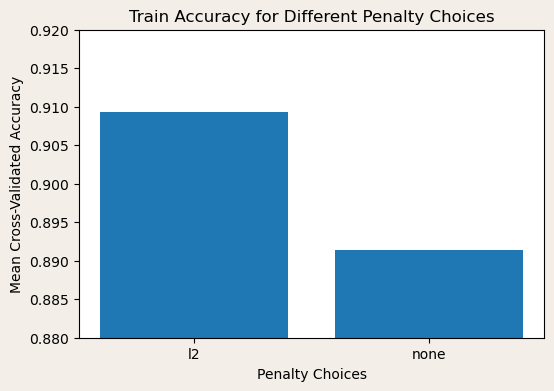

In [51]:
# Access the grid search results
results = grid_search_mlr.cv_results_

# Extract C values and accuracy scores
penalty_values = results['param_multinomial_logistic_regression__penalty'].data
mean_test_scores = results['mean_test_score']

# Plot the accuracy scores against penalty choices
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
ax.bar(penalty_values, mean_test_scores)

# Add plot details
ax.set_ylim(0.88, 0.92)
ax.set_xlabel('Penalty Choices')
ax.set_ylabel('Mean Cross-Validated Accuracy')
ax.set_title('Train Accuracy for Different Penalty Choices')
plt.show()


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Regularisation providing slightly higher score compared to none. Both will be tested with further tuning</li>
</ul>
</div>


*Perform full param search*

In [52]:
# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100], # default = 1 (moderate)
    'multinomial_logistic_regression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], # default = lbfgs 
    'multinomial_logistic_regression__penalty': ['l2', 'none'] # default = l2
}

# Create and fit GridSearchCV object on train data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring='accuracy', cv=cv_mlr, n_jobs = -1)
grid_search_mlr.fit(X_train, y_train)

# Access best hyperparameters and accuracy score
best_params, best_train_score = grid_search_mlr.best_params_, grid_search_mlr.best_score_

# Print the best parameters
display("Best Parameters:", pd.DataFrame(best_params, index=[0]))

# Print the best mean cv training score
print("Mean CV Train Accuracy with best parameters:", settings.score_formatter(best_train_score, 4))

# Evaluate the best model on the test set
best_pipeline = grid_search_mlr.best_estimator_
test_accuracy = best_pipeline.score(X_test, y_test)
print("Test Accuracy with best parameters:", settings.score_formatter(test_accuracy, 4))

# Time to convergence 
print("Iterations to convergence:", best_pipeline['multinomial_logistic_regression'].n_iter_[0])

'Best Parameters:'

,multinomial_logistic_regression__C,multinomial_logistic_regression__penalty,multinomial_logistic_regression__solver
0,1,l2,newton-cg


Mean CV Train Accuracy with best parameters: 90.9300 %
Test Accuracy with best parameters: 88.5000 %


NameError: name 'best_model' is not defined

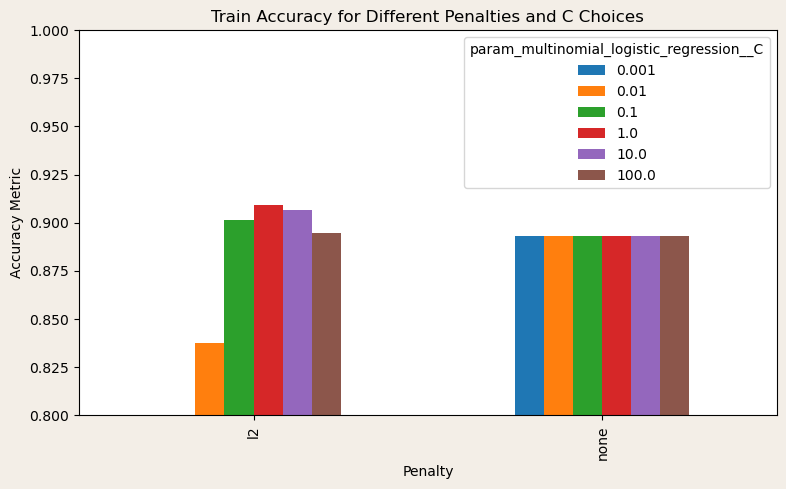

In [59]:
# Access the latest grid search results
results = grid_search_mlr.cv_results_

# Extract penalty, C values and accuracy scores
grouped = pd.DataFrame(results).groupby(["param_multinomial_logistic_regression__penalty","param_multinomial_logistic_regression__C"])["mean_test_score"].mean().unstack()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.8, 1)
ax.set_xlabel('Penalty')
ax.set_ylabel('Accuracy Metric')
ax.set_title('Train Accuracy for Different Penalties and C Choices')
plt.show()

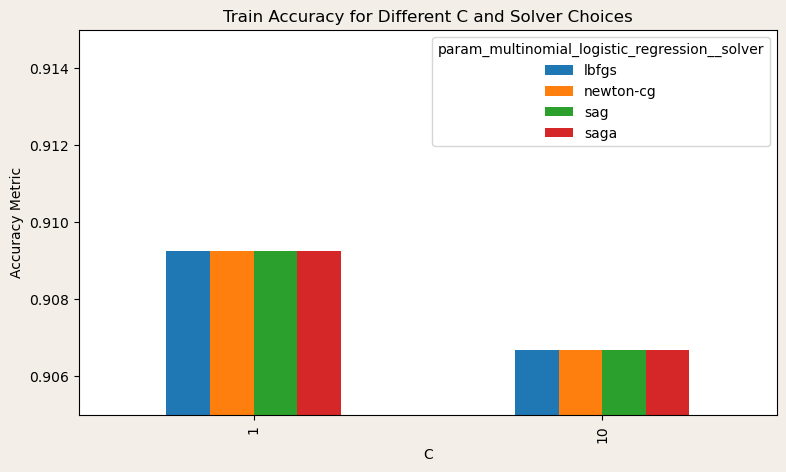

In [60]:
# Extract penalty, C values and accuracy scores
grouped = pd.DataFrame(results)
grouped = grouped[
    (grouped["param_multinomial_logistic_regression__penalty"] == "l2") &
    ((grouped["param_multinomial_logistic_regression__C"] == 1) | (grouped["param_multinomial_logistic_regression__C"] == 10))
].groupby(["param_multinomial_logistic_regression__C", "param_multinomial_logistic_regression__solver"])["mean_test_score"].mean().unstack()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.905, 0.915)
ax.set_xlabel('C')
ax.set_ylabel('Accuracy Metric')
ax.set_title('Train Accuracy for Different C and Solver Choices')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Averaged across all 4 solvers, Regularisation providing higher scores compared to none only for specific strengths (C). This is the case for noteably range of 0.1 to 10</li>
    <li>newton-cg identified as best solver although there is no difference in optimal C range: newton first in param list hence why chosen. Default lbfgs will remain.</li>
</ul>
</div>


*Narrow down C param*

In [120]:
# Refine model and update pipeline
model_mlr = LogisticRegression(multi_class='multinomial', solver="lbfgs", penalty="l2", max_iter=1000, random_state=42) 
pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])

# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__C': np.linspace(0.1, 10, 200), # large sweep of C values
}

# Create and fit GridSearchCV object on training data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring='accuracy', cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

# Access best hyperparameters and accuracy score
best_params, best_train_score = grid_search_mlr.best_params_, grid_search_mlr.best_score_

# Print the best parameters
display("Best Parameters:", pd.DataFrame(best_params, index=[0]))

# Print the best mean cv training score
print("Mean CV Train Accuracy with best parameters:", settings.score_formatter(best_train_score, 4))

# Evaluate the best model on the test set
best_pipeline = grid_search_mlr.best_estimator_
test_accuracy = best_pipeline.score(X_test, y_test)
print("Test Accuracy with best parameters:", settings.score_formatter(test_accuracy, 4))

# Time to convergence 
print("Iterations to convergence:", best_model['multinomial_logistic_regression'].n_iter_[0])

'Best Parameters:'

,multinomial_logistic_regression__C
0,2.637186


Mean CV Train Accuracy with best parameters: 91.05 %
Test Accuracy with best parameters: 89.38000000000001 %
Iterations to convergence: 77


<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul style="list-style-type: none; padding-left: 0;">
    <li style="line-height: 0.1;">
        Best C param across exhaustive grid search is actually all values between ~2.6 and ~5. This is shown by the following code:
        <br>
        <pre style="margin: 0; padding: 10px; border-radius: 5px; background-color: #f7f7f7;">
            <code style="color: #000000; display: block; margin-left: 0; padding-left: 0;">
df = pd.DataFrame(grid_search_mlr.cv_results_)
result = pd.DataFrame(df.groupby("param_multinomial_logistic_regression__C")["mean_test_score"].mean())
            </code>
        </pre>
        Let's select 3.
    </li>
</ul>
<ul>
    <li>Hypertuning slightly improves cv mean train score (and test score).</li>
</ul>


</div>


In [121]:
# Tuning finished: refine model, update and fit pipeline for saving
model_mlr = LogisticRegression(multi_class='multinomial', solver="lbfgs", penalty="l2", C=3, max_iter=1000, random_state=42) 
pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])
pipeline_mlr.fit(X_train, y_train)

# save hypertuned pipeline, verifying better test score
current_best_pipeline = settings.get_saved_pipeline("best_multinomial_logistic_regression_pipeline.pkl")
if current_best_pipeline.score(X_test, y_test) < pipeline_mlr.score(X_test, y_test):
    settings.save_pipeline("best_multinomial_logistic_regression_pipeline.pkl", pipeline_mlr)


*Review metrics for hypertuned model*

In [127]:
# Print test accuracy
print("Test Accuracy:", settings.score_formatter(pipeline_mlr.score(X_test, y_test), 5))

# Generate prediction and show classification report
y_pred = pipeline_mlr.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

Test Accuracy: 89.381 %

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        66
           1       0.79      0.79      0.79        24
           2       0.83      0.83      0.83        23

    accuracy                           0.89       113
   macro avg       0.86      0.86      0.86       113
weighted avg       0.89      0.89      0.89       113



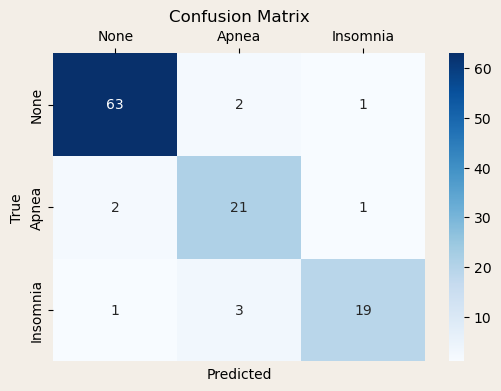

In [145]:
# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

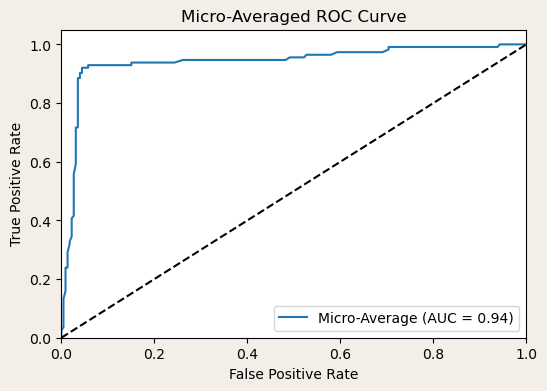

In [153]:
# Predict class probabilities for test data
y_probs = pipeline_mlr.predict_proba(X_test)

# Compute micro-averaged ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(len(class_labels))[y_test].ravel(), y_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

settings.plot_micro_averaged_roc(fpr_micro, tpr_micro, roc_auc_micro)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Accuracy is generally good at ~89% test set and average AUC is high at 95%</li>
    <li>Recall and Precision is better for class 0 ("None") (95%) than those of the sleep disorders</li>
    <li>Apnea has the lowest recall and precision at 79% (5 incorrect out of test 23 instances)</li>
    <li>Insomnia has recall and precision at 83% (5 incorrect out of 24 instances)</li>
</ul>
</div>


*Addressing Class Imbalance: Exploring SMOTE-NC*

In [25]:
# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Proving smote object works using the X array transformed by column_trans
from collections import Counter
smote_x, smote_y = smote_nc.fit_resample(transformed_X_train_df, y_train)
print(f"Original class counts: {Counter(y_train)}")
print(f"New class counts: {Counter(smote_y)}")

Original class counts: Counter({0: 153, 1: 54, 2: 54})
New class counts: Counter({0: 153, 1: 153, 2: 153})


In [136]:
# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ('multinomial_logistic_regression', model_mlr)]
pipeline_mlr = Pipeline_imb(steps)

# Run cross validation on pipeline with train data 
cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring='accuracy', cv=cv_mlr)
print('Mean CV Train Accuracy:', settings.score_formatter(np.mean(cv_scores), 4))

# Fit pipeline with train data and generate test score using model step only (no smote for test)
pipeline_mlr.fit(X_train, y_train)
model_mlr = pipeline_mlr.named_steps['multinomial_logistic_regression']
print('Test Accuracy:', settings.score_formatter(model_mlr.score(transformed_X_test_df.values, y_test), 3))


Mean CV Train Accuracy: 91.05 %
Test Accuracy: 91.2 %


In [139]:
# Generate prediction and show classification report
y_pred = model_mlr.predict(transformed_X_test_df.values)
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        66
           1       0.81      0.88      0.84        24
           2       0.90      0.83      0.86        23

    accuracy                           0.91       113
   macro avg       0.89      0.89      0.89       113
weighted avg       0.91      0.91      0.91       113



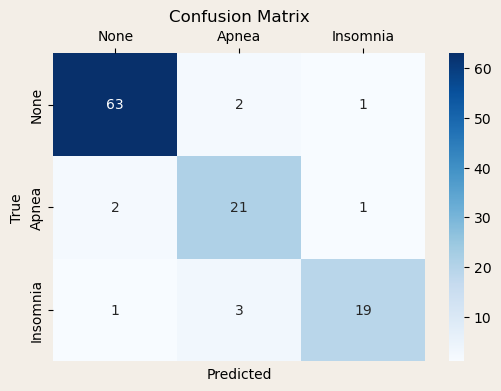

In [146]:
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>SMOTE shows improvement: Recall of Apnea improves by 8% where model makes fewer mistakes classifying Apnea as Insmonia(2 predictions)</li>
</ul>
</div>


In [154]:
# save smote hypertuned pipeline, verifying better test score
current_best_pipeline = settings.get_saved_pipeline("best_multinomial_logistic_regression_pipeline.pkl")
if current_best_pipeline.score(X_test, y_test) < pipeline_mlr.named_steps['multinomial_logistic_regression'].score(transformed_X_test_df.values, y_test):
    settings.save_pipeline("best_multinomial_logistic_regression_pipeline.pkl", pipeline_mlr)

*Testing new features*

*Binning age and dropping original Age*

In [234]:
# re-initialise X array for all features before modification
X = df[settings.ALL_FEATURES]

# Bin age to new column and drop age column
X.loc[:,'Age_bin'] = pd.cut(X.loc[:,'Age'], [20, 30, 40, 50, 60], labels=['20s', '30s', '40s', '50s']).astype("object")
settings.examine_values(X).loc["Age_bin",:]
X = X.drop("Age", axis=1)

C:\Users\adams\AppData\Local\Temp\ipykernel_10420\1932734524.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'Age_bin'] = pd.cut(X.loc[:,'Age'], [20, 30, 40, 50, 60], labels=['20s', '30s', '40s', '50s']).astype("object")


*Split data*

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43, stratify=y)

In [237]:
# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Baseline model*

In [238]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')
    
# create model
model_mlr = LogisticRegression(multi_class='multinomial', max_iter=1000, C=3, random_state=42) # default solver "lgbgs" and penalty "l2"

# create sklearn pipeline
pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])

# create cross validation object for cross_val_score
cv_mlr = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring='accuracy', cv=cv_mlr)
display(f'Mean CV Train Accuracy: {np.round(np.mean(cv_scores), 6)*100} %')

# fit pipeline and produce test score 
pipeline_mlr.fit(X_train, y_train)
display(f'Test Accuracy:{np.round(pipeline_mlr.score(X_test, y_test), 6)*100} %')

'Mean CV Train Accuracy: 91.1805 %'

'Test Accuracy:89.3805 %'

In [242]:
# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100], # default = 1 (moderate)
    'multinomial_logistic_regression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], # default = lbfgs 
    'multinomial_logistic_regression__penalty': ['l2', 'none'] # default = l2
}

# Create and fit GridSearchCV object on train data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring='accuracy', cv=cv_mlr, n_jobs = -1)
grid_search_mlr.fit(X_train, y_train)

settings.get_gridsearchcv_summary(grid_search_mlr, 4, X_test, y_test)


'Best Parameters:'

,multinomial_logistic_regression__C,multinomial_logistic_regression__penalty,multinomial_logistic_regression__solver
0,1,l2,newton-cg


Mean CV Train Accuracy with best parameters: 91.1800 %
Test Accuracy with best parameters: 88.5000 %
Iterations to convergence: 77


In [ ]:
# Refine model and update pipeline
model_mlr = LogisticRegression(multi_class='multinomial', solver="lbfgs", penalty="l2", max_iter=1000, random_state=42) 
pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])

# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__C': np.linspace(0.1, 10, 200), # large sweep of C values
}

# Create and fit GridSearchCV object on training data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring='accuracy', cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

settings.get_gridsearchcv_summary(grid_search_mlr, 4, X_test, y_test)


In [241]:
# Refine model
model_mlr = LogisticRegression(multi_class='multinomial', solver="lbfgs", penalty="l2", C = 0.4, max_iter=1000, random_state=42) 

# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ('multinomial_logistic_regression', model_mlr)]
pipeline_mlr = Pipeline_imb(steps)

# Run cross validation on pipeline with train data 
cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring='accuracy', cv=cv_mlr)
print('Mean CV Train Accuracy:', settings.score_formatter(np.mean(cv_scores), 4))

# Fit pipeline with train data and generate test score using model step only (no smote for test)
pipeline_mlr.fit(X_train, y_train)
model_mlr = pipeline_mlr.named_steps['multinomial_logistic_regression']
print('Test Accuracy:', settings.score_formatter(model_mlr.score(transformed_X_test_df.values, y_test), 3))


Mean CV Train Accuracy: 91.0500 %
Test Accuracy: 88.500 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Age binning doesn't improve on best model</li>
</ul>
</div>


*Dropping highly correlated features*

In [280]:
# re-initialise X array for all features before modification
X = df[settings.ALL_FEATURES]

# Drop age to new column and drop age column
X = X.drop(["Quality of Sleep", "Stress Level"], axis=1) # "Quality of Sleep", "Stress Level"

*Split data*

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43, stratify=y)

In [282]:
# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Baseline model*

In [283]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')
    
# create model
model_mlr = LogisticRegression(multi_class='multinomial', max_iter=1000, C=3, random_state=42) # default solver "lgbgs" and penalty "l2"

# create sklearn pipeline
pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])

# create cross validation object for cross_val_score
cv_mlr = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring='accuracy', cv=cv_mlr)
display(f'Mean CV Train Accuracy: {np.round(np.mean(cv_scores), 6)*100} %')

# fit pipeline and produce test score 
pipeline_mlr.fit(X_train, y_train)
display(f'Test Accuracy:{np.round(pipeline_mlr.score(X_test, y_test), 6)*100} %')

'Mean CV Train Accuracy: 91.1805 %'

'Test Accuracy:91.1504 %'

In [284]:
# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100], # default = 1 (moderate)
    'multinomial_logistic_regression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], # default = lbfgs 
    'multinomial_logistic_regression__penalty': ['l2', 'none'] # default = l2
}

# Create and fit GridSearchCV object on train data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring='accuracy', cv=cv_mlr, n_jobs = -1)
grid_search_mlr.fit(X_train, y_train)

settings.get_gridsearchcv_summary(grid_search_mlr, 4, X_test, y_test)


'Best Parameters:'

,multinomial_logistic_regression__C,multinomial_logistic_regression__penalty,multinomial_logistic_regression__solver
0,1,l2,newton-cg


Mean CV Train Accuracy with best parameters: 91.1800 %
Test Accuracy with best parameters: 88.5000 %


In [285]:
# Refine model and update pipeline
model_mlr = LogisticRegression(multi_class='multinomial', solver="lbfgs", penalty="l2", max_iter=1000, random_state=42) 
pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])

# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__C': np.linspace(0.1, 10, 200), # large sweep of C values
}

# Create and fit GridSearchCV object on training data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring='accuracy', cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

settings.get_gridsearchcv_summary(grid_search_mlr, 4, X_test, y_test)


'Best Parameters:'

,multinomial_logistic_regression__C
0,2.338693


Mean CV Train Accuracy with best parameters: 91.3100 %
Test Accuracy with best parameters: 88.5000 %


In [287]:
# Refine model
model_mlr = LogisticRegression(multi_class='multinomial', solver="lbfgs", penalty="l2", C = 2.4, max_iter=1000, random_state=42) 

# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ('multinomial_logistic_regression', model_mlr)]
pipeline_mlr = Pipeline_imb(steps)

# Run cross validation on pipeline with train data 
cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring='accuracy', cv=cv_mlr)
print('Mean CV Train Accuracy:', settings.score_formatter(np.mean(cv_scores), 4))
666666666
# Fit pipeline with train data and generate test score using model step only (no smote for test)
pipeline_mlr.fit(X_train, y_train)
model_mlr = pipeline_mlr.named_steps['multinomial_logistic_regression']
print('Test Accuracy:', settings.score_formatter(model_mlr.score(transformed_X_test_df.values, y_test), 3))


Mean CV Train Accuracy: 91.5700 %
Test Accuracy: 85.000 %


https://www.kaggle.com/code/jillanisofttech/sleep-health-and-lifestyle-predication-with-94-ac

- KNN (deminensionality reduction needed)